# Malls In Berlin

## Import Libraries

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, Table, Column, Integer, String, MetaData, ForeignKey, Float, BigInteger
import psycopg2
import warnings
import requests
import time
import logging

warnings.filterwarnings("ignore")

## Connect to Database

In [ ]:
user_name='hakim_murphy'
password='R7y12MdUu6L3w8wC'

In [ ]:
host = 'localhost'
port = '5433'
database = 'layereddb'
schema='berlin_source_data'

#connection to db after you opened tunnel
engine = create_engine(f'postgresql+psycopg2://{user_name}:{password}@{host}:{port}/{database}')

## Import CSV

In [2]:
df = pd.read_csv("../sources/osm_malls_with_boundaries.csv")
df.head()

,osm_type,osm_id,name_left,website,opening_hours,addr_street,addr_housenumber,addr_postcode,addr_city,lat,...,gem_left,namgem_left,namlan_left,lan_left,index__neigh,name,gem__neigh,namgem__neigh,namlan__neigh,lan__neigh
0,node,360009454,Cladow-Center,NaN,NaN,NaN,NaN,NaN,NaN,52.455157,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node,2782835444,Nordmeile,NaN,Mo-Sa 07:00-21:00,Oraniendamm,6-10,13469.0,Berlin,52.607867,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node,3982921774,Springpfuhl-Passage,NaN,NaN,NaN,NaN,NaN,NaN,52.526728,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node,5024078544,Fennpfuhl-Karree,NaN,24/7,NaN,NaN,NaN,NaN,52.528781,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,way,10632546,Hallen am Borsigturm,http://www.hab-2.de,Mo-Sa 10:00-20:00,Am Borsigturm,2,13507.0,Berlin,52.584576,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploring the Data

In [3]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,103
osm_type,node,node,node,node,way,way,way,way,way,way,...,way,way,way,relation,relation,relation,relation,relation,relation,relation
osm_id,360009454,2782835444,3982921774,5024078544,10632546,11076700,11249452,11249566,18771934,20980117,...,1065811824,1238152790,1244901436,380240,2671992,4540346,7701165,8504555,17353905,19445153
name_left,Cladow-Center,Nordmeile,Springpfuhl-Passage,Fennpfuhl-Karree,Hallen am Borsigturm,Einkaufszentrum »Der Clou«,Linden Center,Allee-Center Berlin,Bahnhof Lichtenberg,Gesundbrunnen-Center,...,Ring-Center Berlin II,Tempelhofer Hafen,Märkisches Zentrum,The Q,NaN,Neumann-Forum,Gropius Passagen,Forum Landsberger Allee,GEHAG Einkaufzentrum,Dolgensee-Center
website,NaN,NaN,NaN,NaN,http://www.hab-2.de,https://www.derclouberlin.de/,https://m.linden-center-berlin.de,NaN,NaN,https://www.gesundbrunnen-center.de/,...,NaN,NaN,https://www.maerkisches-zentrum.de/,NaN,NaN,NaN,https://www.gropius-passagen.de/,NaN,NaN,NaN
opening_hours,NaN,Mo-Sa 07:00-21:00,NaN,24/7,Mo-Sa 10:00-20:00,Mo-Sa 10:00-20:00,Mo-Sa 09:30-20:00,Mo-Sa 07:00-20:00,06:00-22:00,Mo-Sa 08:00-21:00,...,Mo-Sa 10:00-20:00; PH off,Mo-Sa 10:00-20:00,NaN,Mo-Sa 08:00-22:00,NaN,Mo-Sa 07:00-21:00,Mo-Sa 10:00-20:00,NaN,NaN,NaN
addr_street,NaN,Oraniendamm,NaN,NaN,Am Borsigturm,Scharnweberstraße,Prerower Platz,Landsberger Allee,Weitlingstraße,Badstraße,...,Frankfurter Allee,NaN,Senftenberger Ring,Friedrichstraße,NaN,NaN,NaN,NaN,NaN,NaN
addr_housenumber,NaN,6-10,NaN,NaN,2,140,1,277,22,4,...,113-117,NaN,3a,67,NaN,NaN,NaN,NaN,NaN,NaN
addr_postcode,NaN,13469.0,NaN,NaN,13507.0,13405.0,13051.0,13055.0,10317.0,13357.0,...,10365.0,NaN,13439.0,10117.0,NaN,NaN,NaN,NaN,NaN,NaN
addr_city,NaN,Berlin,NaN,NaN,Berlin,Berlin,Berlin,Berlin,Berlin,Berlin,...,Berlin,NaN,Berlin,Berlin,NaN,NaN,NaN,NaN,NaN,NaN
lat,52.455157,52.607867,52.526728,52.528781,52.584576,52.563039,52.564378,52.535248,52.509421,52.549773,...,52.514327,52.455806,52.597613,52.512614,52.522378,52.561378,52.430128,52.52926,52.437559,52.493574


In [4]:
df = df.drop_duplicates()

In [5]:
df.isna().sum()

osm_type              0
osm_id                0
name_left             4
website              76
opening_hours        41
addr_street          41
addr_housenumber     42
addr_postcode        41
addr_city            45
lat                   0
lon                   0
wheelchair           23
operator             98
brand               103
start_date           96
level               104
source                0
geometry              0
index__district     104
name__district      104
gem_left            104
namgem_left         104
namlan_left         104
lan_left            104
index__neigh        104
name                104
gem__neigh          104
namgem__neigh       104
namlan__neigh       104
lan__neigh          104
dtype: int64

In [6]:
df_columns_drop = df.copy()
columns_to_drop = [
    'operator', 
    'brand',
    'start_date', 
    'level', 
    'gem_left',
    'namgem_left',
    'namlan_left',
    'lan_left',
    'index__neigh',
    'name',
    'gem__neigh',
    'namgem__neigh',
    'namlan__neigh',
    'lan__neigh'
]  
df_kept = df_columns_drop.drop(columns=columns_to_drop)
df_kept.head()

,osm_type,osm_id,name_left,website,opening_hours,addr_street,addr_housenumber,addr_postcode,addr_city,lat,lon,wheelchair,source,geometry,index__district,name__district
0,node,360009454,Cladow-Center,NaN,NaN,NaN,NaN,NaN,NaN,52.455157,13.144413,yes,OSM Overpass,POINT (13.1444131 52.4551567),NaN,NaN
1,node,2782835444,Nordmeile,NaN,Mo-Sa 07:00-21:00,Oraniendamm,6-10,13469.0,Berlin,52.607867,13.325992,NaN,OSM Overpass,POINT (13.3259918 52.6078674),NaN,NaN
2,node,3982921774,Springpfuhl-Passage,NaN,NaN,NaN,NaN,NaN,NaN,52.526728,13.540104,yes,OSM Overpass,POINT (13.5401045 52.5267284),NaN,NaN
3,node,5024078544,Fennpfuhl-Karree,NaN,24/7,NaN,NaN,NaN,NaN,52.528781,13.471797,yes,OSM Overpass,POINT (13.4717971 52.5287807),NaN,NaN
4,way,10632546,Hallen am Borsigturm,http://www.hab-2.de,Mo-Sa 10:00-20:00,Am Borsigturm,2,13507.0,Berlin,52.584576,13.285772,yes,OSM Overpass,POINT (13.2857717 52.5845756),NaN,NaN


In [ ]:
df_kept.dtypes

In [ ]:
df_kept.isna().sum() 

### Dealing with Null Values

In [7]:
df_kept = df_kept.fillna({
    'name_left': 'None',
    'website': 'None',
    'opening_hours': 'None',
    'addr_street': 'None',
    'addr_housenumber': '',
    'addr_postcode': '',
    'addr_city': '',
    'wheelchair': 'None',
    'index__district': '',
    'name__district': ''
})

In [8]:
df_kept.isna().sum()

osm_type            0
osm_id              0
name_left           0
website             0
opening_hours       0
addr_street         0
addr_housenumber    0
addr_postcode       0
addr_city           0
lat                 0
lon                 0
wheelchair          0
source              0
geometry            0
index__district     0
name__district      0
dtype: int64

In [9]:
df_kept

,osm_type,osm_id,name_left,website,opening_hours,addr_street,addr_housenumber,addr_postcode,addr_city,lat,lon,wheelchair,source,geometry,index__district,name__district
0,node,360009454,Cladow-Center,None,None,None,,,,52.455157,13.144413,yes,OSM Overpass,POINT (13.1444131 52.4551567),,
1,node,2782835444,Nordmeile,None,Mo-Sa 07:00-21:00,Oraniendamm,6-10,13469.0,Berlin,52.607867,13.325992,None,OSM Overpass,POINT (13.3259918 52.6078674),,
2,node,3982921774,Springpfuhl-Passage,None,None,None,,,,52.526728,13.540104,yes,OSM Overpass,POINT (13.5401045 52.5267284),,
3,node,5024078544,Fennpfuhl-Karree,None,24/7,None,,,,52.528781,13.471797,yes,OSM Overpass,POINT (13.4717971 52.5287807),,
4,way,10632546,Hallen am Borsigturm,http://www.hab-2.de,Mo-Sa 10:00-20:00,Am Borsigturm,2,13507.0,Berlin,52.584576,13.285772,yes,OSM Overpass,POINT (13.2857717 52.5845756),,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,relation,4540346,Neumann-Forum,None,Mo-Sa 07:00-21:00,None,,,,52.561378,13.422762,None,OSM Overpass,POINT (13.4227619 52.5613783),,
100,relation,7701165,Gropius Passagen,https://www.gropius-passagen.de/,Mo-Sa 10:00-20:00,None,,,,52.430128,13.455199,yes,OSM Overpass,POINT (13.4551989 52.4301282),,
101,relation,8504555,Forum Landsberger Allee,None,None,None,,,,52.529260,13.456340,yes,OSM Overpass,POINT (13.4563404 52.5292601),,
102,relation,17353905,GEHAG Einkaufzentrum,None,None,None,,,,52.437559,13.446334,None,OSM Overpass,POINT (13.4463336 52.4375589),,


### Rename Columns

In [10]:
df_kept = df_kept.rename(columns={
    'osm_id': 'id',
    'name_left': 'name',
    'addr_street': 'street',
    'addr_housenumber': 'housenumber',
    'addr_postcode': 'postcode',
    'addr_city': 'city',
    'lat': 'latitude',
    'lon': 'longitude',
    'index__district': 'district_id',
    'name__district': 'district'   
})

In [11]:
for col in df_kept.select_dtypes(include='object').columns:
    df_kept[col] = df_kept[col].astype(str).str.strip().str.title()

In [12]:
df_kept.T

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,103
osm_type,Node,Node,Node,Node,Way,Way,Way,Way,Way,Way,...,Way,Way,Way,Relation,Relation,Relation,Relation,Relation,Relation,Relation
id,360009454,2782835444,3982921774,5024078544,10632546,11076700,11249452,11249566,18771934,20980117,...,1065811824,1238152790,1244901436,380240,2671992,4540346,7701165,8504555,17353905,19445153
name,Cladow-Center,Nordmeile,Springpfuhl-Passage,Fennpfuhl-Karree,Hallen Am Borsigturm,Einkaufszentrum »Der Clou«,Linden Center,Allee-Center Berlin,Bahnhof Lichtenberg,Gesundbrunnen-Center,...,Ring-Center Berlin Ii,Tempelhofer Hafen,Märkisches Zentrum,The Q,None,Neumann-Forum,Gropius Passagen,Forum Landsberger Allee,Gehag Einkaufzentrum,Dolgensee-Center
website,None,None,None,None,Http://Www.Hab-2.De,Https://Www.Derclouberlin.De/,Https://M.Linden-Center-Berlin.De,None,None,Https://Www.Gesundbrunnen-Center.De/,...,None,None,Https://Www.Maerkisches-Zentrum.De/,None,None,None,Https://Www.Gropius-Passagen.De/,None,None,None
opening_hours,None,Mo-Sa 07:00-21:00,None,24/7,Mo-Sa 10:00-20:00,Mo-Sa 10:00-20:00,Mo-Sa 09:30-20:00,Mo-Sa 07:00-20:00,06:00-22:00,Mo-Sa 08:00-21:00,...,Mo-Sa 10:00-20:00; Ph Off,Mo-Sa 10:00-20:00,None,Mo-Sa 08:00-22:00,None,Mo-Sa 07:00-21:00,Mo-Sa 10:00-20:00,None,None,None
street,None,Oraniendamm,None,None,Am Borsigturm,Scharnweberstraße,Prerower Platz,Landsberger Allee,Weitlingstraße,Badstraße,...,Frankfurter Allee,None,Senftenberger Ring,Friedrichstraße,None,None,None,None,None,None
housenumber,,6-10,,,2,140,1,277,22,4,...,113-117,,3A,67,,,,,,
postcode,,13469.0,,,13507.0,13405.0,13051.0,13055.0,10317.0,13357.0,...,10365.0,,13439.0,10117.0,,,,,,
city,,Berlin,,,Berlin,Berlin,Berlin,Berlin,Berlin,Berlin,...,Berlin,,Berlin,Berlin,,,,,,
latitude,52.455157,52.607867,52.526728,52.528781,52.584576,52.563039,52.564378,52.535248,52.509421,52.549773,...,52.514327,52.455806,52.597613,52.512614,52.522378,52.561378,52.430128,52.52926,52.437559,52.493574


In [13]:
df_kept.dtypes

osm_type          object
id                 int64
name              object
website           object
opening_hours     object
street            object
housenumber       object
postcode          object
city              object
latitude         float64
longitude        float64
wheelchair        object
source            object
geometry          object
district_id       object
district          object
dtype: object

### Changing Datatypes

In [14]:
df_kept['postcode'] = pd.to_numeric(df_kept['postcode'], errors='coerce').astype('Int64')

In [15]:
df_kept['district_id'] = pd.to_numeric(df_kept['district_id'], errors='coerce').astype('Int64')

In [16]:
df_kept.dtypes

osm_type          object
id                 int64
name              object
website           object
opening_hours     object
street            object
housenumber       object
postcode           Int64
city              object
latitude         float64
longitude        float64
wheelchair        object
source            object
geometry          object
district_id        Int64
district          object
dtype: object

In [17]:
df_kept['postcode'] = df_kept['postcode'].fillna(0).astype('int64')

### Checking Datatypes for 'city' column

In [18]:
df_kept.value_counts('city')

city
Berlin    59
          45
Name: count, dtype: int64

In [19]:
in_berlin = (
    (df_kept['latitude'] >= 52.3383) & (df_kept['latitude'] <= 52.6755) &
    (df_kept['longitude'] >= 13.0884) & (df_kept['longitude'] <= 13.7612)
)
print(f"All coordinates in Berlin: {in_berlin.all()}")
print(f"Rows outside Berlin: {df_kept[~in_berlin]}")

All coordinates in Berlin: True
Rows outside Berlin: Empty DataFrame
Columns: [osm_type, id, name, website, opening_hours, street, housenumber, postcode, city, latitude, longitude, wheelchair, source, geometry, district_id, district]
Index: []


In [20]:
df_kept['city'] = df_kept['city'].replace('', 'Berlin')

In [21]:
df_kept['housenumber'] = df_kept['housenumber'].replace('', 'None')

## Find district, district_id

In [22]:
df_kept.T

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,103
osm_type,Node,Node,Node,Node,Way,Way,Way,Way,Way,Way,...,Way,Way,Way,Relation,Relation,Relation,Relation,Relation,Relation,Relation
id,360009454,2782835444,3982921774,5024078544,10632546,11076700,11249452,11249566,18771934,20980117,...,1065811824,1238152790,1244901436,380240,2671992,4540346,7701165,8504555,17353905,19445153
name,Cladow-Center,Nordmeile,Springpfuhl-Passage,Fennpfuhl-Karree,Hallen Am Borsigturm,Einkaufszentrum »Der Clou«,Linden Center,Allee-Center Berlin,Bahnhof Lichtenberg,Gesundbrunnen-Center,...,Ring-Center Berlin Ii,Tempelhofer Hafen,Märkisches Zentrum,The Q,None,Neumann-Forum,Gropius Passagen,Forum Landsberger Allee,Gehag Einkaufzentrum,Dolgensee-Center
website,None,None,None,None,Http://Www.Hab-2.De,Https://Www.Derclouberlin.De/,Https://M.Linden-Center-Berlin.De,None,None,Https://Www.Gesundbrunnen-Center.De/,...,None,None,Https://Www.Maerkisches-Zentrum.De/,None,None,None,Https://Www.Gropius-Passagen.De/,None,None,None
opening_hours,None,Mo-Sa 07:00-21:00,None,24/7,Mo-Sa 10:00-20:00,Mo-Sa 10:00-20:00,Mo-Sa 09:30-20:00,Mo-Sa 07:00-20:00,06:00-22:00,Mo-Sa 08:00-21:00,...,Mo-Sa 10:00-20:00; Ph Off,Mo-Sa 10:00-20:00,None,Mo-Sa 08:00-22:00,None,Mo-Sa 07:00-21:00,Mo-Sa 10:00-20:00,None,None,None
street,None,Oraniendamm,None,None,Am Borsigturm,Scharnweberstraße,Prerower Platz,Landsberger Allee,Weitlingstraße,Badstraße,...,Frankfurter Allee,None,Senftenberger Ring,Friedrichstraße,None,None,None,None,None,None
housenumber,None,6-10,None,None,2,140,1,277,22,4,...,113-117,None,3A,67,None,None,None,None,None,None
postcode,0,13469,0,0,13507,13405,13051,13055,10317,13357,...,10365,0,13439,10117,0,0,0,0,0,0
city,Berlin,Berlin,Berlin,Berlin,Berlin,Berlin,Berlin,Berlin,Berlin,Berlin,...,Berlin,Berlin,Berlin,Berlin,Berlin,Berlin,Berlin,Berlin,Berlin,Berlin
latitude,52.455157,52.607867,52.526728,52.528781,52.584576,52.563039,52.564378,52.535248,52.509421,52.549773,...,52.514327,52.455806,52.597613,52.512614,52.522378,52.561378,52.430128,52.52926,52.437559,52.493574


In [23]:
df_kept.drop(columns=['district_id', 'district'], errors='ignore', inplace=True)

In [25]:
desired_order = [
    "id", "osm_type", "name", "website", "opening_hours", "street", "housenumber",
    "postcode", "city", "latitude", "longitude", "wheelchair", "source", "geometry"
]
df_kept = df_kept[desired_order]

In [26]:
df_kept.T

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,103
id,360009454,2782835444,3982921774,5024078544,10632546,11076700,11249452,11249566,18771934,20980117,...,1065811824,1238152790,1244901436,380240,2671992,4540346,7701165,8504555,17353905,19445153
osm_type,Node,Node,Node,Node,Way,Way,Way,Way,Way,Way,...,Way,Way,Way,Relation,Relation,Relation,Relation,Relation,Relation,Relation
name,Cladow-Center,Nordmeile,Springpfuhl-Passage,Fennpfuhl-Karree,Hallen Am Borsigturm,Einkaufszentrum »Der Clou«,Linden Center,Allee-Center Berlin,Bahnhof Lichtenberg,Gesundbrunnen-Center,...,Ring-Center Berlin Ii,Tempelhofer Hafen,Märkisches Zentrum,The Q,None,Neumann-Forum,Gropius Passagen,Forum Landsberger Allee,Gehag Einkaufzentrum,Dolgensee-Center
website,None,None,None,None,Http://Www.Hab-2.De,Https://Www.Derclouberlin.De/,Https://M.Linden-Center-Berlin.De,None,None,Https://Www.Gesundbrunnen-Center.De/,...,None,None,Https://Www.Maerkisches-Zentrum.De/,None,None,None,Https://Www.Gropius-Passagen.De/,None,None,None
opening_hours,None,Mo-Sa 07:00-21:00,None,24/7,Mo-Sa 10:00-20:00,Mo-Sa 10:00-20:00,Mo-Sa 09:30-20:00,Mo-Sa 07:00-20:00,06:00-22:00,Mo-Sa 08:00-21:00,...,Mo-Sa 10:00-20:00; Ph Off,Mo-Sa 10:00-20:00,None,Mo-Sa 08:00-22:00,None,Mo-Sa 07:00-21:00,Mo-Sa 10:00-20:00,None,None,None
street,None,Oraniendamm,None,None,Am Borsigturm,Scharnweberstraße,Prerower Platz,Landsberger Allee,Weitlingstraße,Badstraße,...,Frankfurter Allee,None,Senftenberger Ring,Friedrichstraße,None,None,None,None,None,None
housenumber,None,6-10,None,None,2,140,1,277,22,4,...,113-117,None,3A,67,None,None,None,None,None,None
postcode,0,13469,0,0,13507,13405,13051,13055,10317,13357,...,10365,0,13439,10117,0,0,0,0,0,0
city,Berlin,Berlin,Berlin,Berlin,Berlin,Berlin,Berlin,Berlin,Berlin,Berlin,...,Berlin,Berlin,Berlin,Berlin,Berlin,Berlin,Berlin,Berlin,Berlin,Berlin
latitude,52.455157,52.607867,52.526728,52.528781,52.584576,52.563039,52.564378,52.535248,52.509421,52.549773,...,52.514327,52.455806,52.597613,52.512614,52.522378,52.561378,52.430128,52.52926,52.437559,52.493574


In [ ]:
# neighborhoods = gpd.read_file("lor_ortsteile.geojson").to_crs("EPSG:4326")

geojson_path = "../sources/wfs_downloads/lor_ortsteile.geojson"
neighborhoods = gpd.read_file(geojson_path).to_crs("EPSG:4326")

neighborhoods = neighborhoods.rename(columns={
    "BEZIRK": "district",
    "OTEIL": "neighborhood",
    "spatial_name": "neighborhood_id"
})

neighborhoods.head()

,gml_id,neighborhood_id,spatial_alias,spatial_type,neighborhood,district,FLAECHE_HA,geometry
0,re_ortsteil.0101,0101,Mitte,Polygon,Mitte,Mitte,1063.8748,"POLYGON ((13.41649 52.52696, 13.41635 52.52702..."
1,re_ortsteil.0102,0102,Moabit,Polygon,Moabit,Mitte,768.7909,"POLYGON ((13.33884 52.51974, 13.33884 52.51974..."
2,re_ortsteil.0103,0103,Hansaviertel,Polygon,Hansaviertel,Mitte,52.5337,"POLYGON ((13.34322 52.51557, 13.34323 52.51557..."
3,re_ortsteil.0104,0104,Tiergarten,Polygon,Tiergarten,Mitte,516.0672,"POLYGON ((13.36879 52.49878, 13.36891 52.49877..."
4,re_ortsteil.0105,0105,Wedding,Polygon,Wedding,Mitte,919.9112,"POLYGON ((13.34656 52.53879, 13.34664 52.53878..."


In [32]:
# If you have latitude and longitude columns:
df_clean = df_kept.copy()
df_clean['geometry'] = df_clean.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
df_clean = gpd.GeoDataFrame(df_clean, geometry='geometry', crs='EPSG:4326')

In [ ]:
df_with_districts = gpd.sjoin(
    df_clean, 
    neighborhoods[["district", "neighborhood", "neighborhood_id", "geometry"]],
    how="left",
    predicate="within"
)

df_final = df_with_districts.drop(columns=["geometry", "index_right"])

In [34]:
df_final.head()

,id,osm_type,name,website,opening_hours,street,housenumber,postcode,city,latitude,longitude,wheelchair,source,district,neighborhood,neighborhood_id
0,360009454,Node,Cladow-Center,None,None,None,None,0,Berlin,52.455157,13.144413,Yes,Osm Overpass,Spandau,Kladow,0506
1,2782835444,Node,Nordmeile,None,Mo-Sa 07:00-21:00,Oraniendamm,6-10,13469,Berlin,52.607867,13.325992,None,Osm Overpass,Reinickendorf,Waidmannslust,1207
2,3982921774,Node,Springpfuhl-Passage,None,None,None,None,0,Berlin,52.526728,13.540104,Yes,Osm Overpass,Marzahn-Hellersdorf,Marzahn,1001
3,5024078544,Node,Fennpfuhl-Karree,None,24/7,None,None,0,Berlin,52.528781,13.471797,Yes,Osm Overpass,Lichtenberg,Fennpfuhl,1111
4,10632546,Way,Hallen Am Borsigturm,Http://Www.Hab-2.De,Mo-Sa 10:00-20:00,Am Borsigturm,2,13507,Berlin,52.584576,13.285772,Yes,Osm Overpass,Reinickendorf,Tegel,1202


In [ ]:
# https://www.regionalstatistik.de

district_mapping = {
    'Mitte': '11001001',
    'Friedrichshain-Kreuzberg': '11002002',
    'Pankow': '11003003',
    'Charlottenburg-Wilmersdorf': '11004004',
    'Spandau': '11005005',
    'Steglitz-Zehlendorf': '11006006',
    'Tempelhof-Schöneberg': '11007007',
    'Neukölln': '11008008',
    'Treptow-Köpenick': '11009009',
    'Marzahn-Hellersdorf': '11010010',
    'Lichtenberg': '11011011',
    'Reinickendorf': '11012012'
}

df_final['district_id'] = df_final['district'].map(district_mapping).astype(str)

unmapped = df_final[~df_final['district'].isin(district_mapping.keys())]['district'].unique()
if len(unmapped) > 0:
    print("⚠️ Unmapped districts found:", unmapped)

df_final.head()

,id,osm_type,name,website,opening_hours,street,housenumber,postcode,city,latitude,longitude,wheelchair,source,district,neighborhood,neighborhood_id,district_id
0,360009454,Node,Cladow-Center,None,None,None,None,0,Berlin,52.455157,13.144413,Yes,Osm Overpass,Spandau,Kladow,0506,11005005
1,2782835444,Node,Nordmeile,None,Mo-Sa 07:00-21:00,Oraniendamm,6-10,13469,Berlin,52.607867,13.325992,None,Osm Overpass,Reinickendorf,Waidmannslust,1207,11012012
2,3982921774,Node,Springpfuhl-Passage,None,None,None,None,0,Berlin,52.526728,13.540104,Yes,Osm Overpass,Marzahn-Hellersdorf,Marzahn,1001,11010010
3,5024078544,Node,Fennpfuhl-Karree,None,24/7,None,None,0,Berlin,52.528781,13.471797,Yes,Osm Overpass,Lichtenberg,Fennpfuhl,1111,11011011
4,10632546,Way,Hallen Am Borsigturm,Http://Www.Hab-2.De,Mo-Sa 10:00-20:00,Am Borsigturm,2,13507,Berlin,52.584576,13.285772,Yes,Osm Overpass,Reinickendorf,Tegel,1202,11012012


In [40]:
df_final.head().T

,0,1,2,3,4
id,360009454,2782835444,3982921774,5024078544,10632546
osm_type,Node,Node,Node,Node,Way
name,Cladow-Center,Nordmeile,Springpfuhl-Passage,Fennpfuhl-Karree,Hallen Am Borsigturm
website,None,None,None,None,Http://Www.Hab-2.De
opening_hours,None,Mo-Sa 07:00-21:00,None,24/7,Mo-Sa 10:00-20:00
street,None,Oraniendamm,None,None,Am Borsigturm
housenumber,None,6-10,None,None,2
postcode,0,13469,0,0,13507
city,Berlin,Berlin,Berlin,Berlin,Berlin
latitude,52.455157,52.607867,52.526728,52.528781,52.584576


In [41]:
df_final.isna().sum()

id                 0
osm_type           0
name               0
website            0
opening_hours      0
street             0
housenumber        0
postcode           0
city               0
latitude           0
longitude          0
wheelchair         0
source             0
district           0
neighborhood       0
neighborhood_id    0
district_id        0
dtype: int64

In [43]:
df_final['neighborhood_id'] = pd.to_numeric(df_final['neighborhood_id'], errors='coerce').astype('Int64')
df_final['district_id'] = pd.to_numeric(df_final['district_id'], errors='coerce').astype('Int64')

In [44]:
df_final.dtypes

id                   int64
osm_type            object
name                object
website             object
opening_hours       object
street              object
housenumber         object
postcode             int64
city                object
latitude           float64
longitude          float64
wheelchair          object
source              object
district            object
neighborhood        object
neighborhood_id      Int64
district_id          Int64
dtype: object

In [45]:
df_final.head().T

,0,1,2,3,4
id,360009454,2782835444,3982921774,5024078544,10632546
osm_type,Node,Node,Node,Node,Way
name,Cladow-Center,Nordmeile,Springpfuhl-Passage,Fennpfuhl-Karree,Hallen Am Borsigturm
website,None,None,None,None,Http://Www.Hab-2.De
opening_hours,None,Mo-Sa 07:00-21:00,None,24/7,Mo-Sa 10:00-20:00
street,None,Oraniendamm,None,None,Am Borsigturm
housenumber,None,6-10,None,None,2
postcode,0,13469,0,0,13507
city,Berlin,Berlin,Berlin,Berlin,Berlin
latitude,52.455157,52.607867,52.526728,52.528781,52.584576


## Map of malls in Berlin

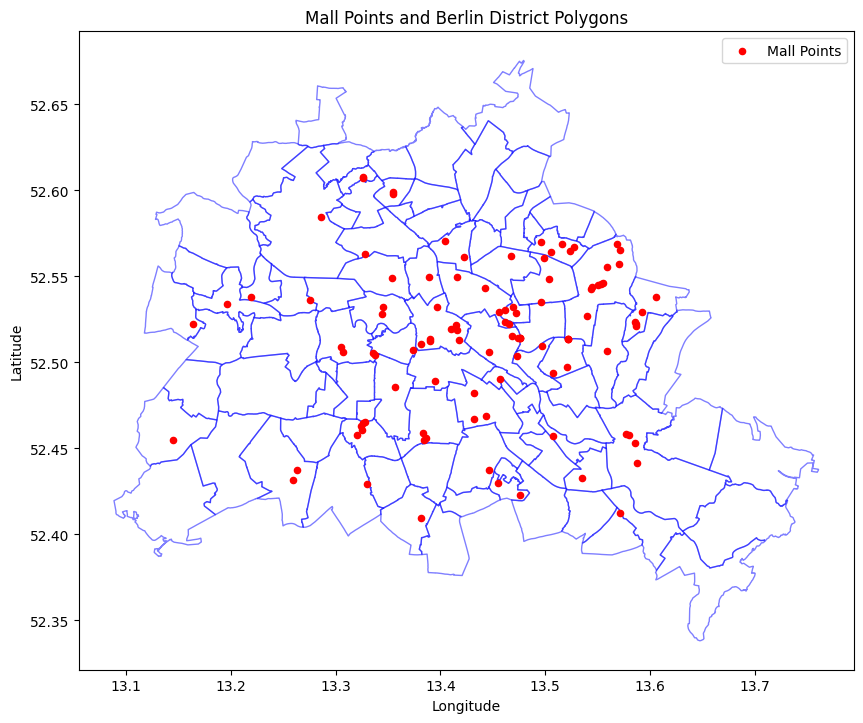

In [47]:
fig, ax = plt.subplots(figsize=(10, 10))
neighborhoods.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1, alpha=0.5, label='District Polygons')
df_clean.plot(ax=ax, color='red', markersize=20, label='Mall Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mall Points and Berlin District Polygons')
plt.legend()
plt.show()

In [ ]:
engine.dispose()

## Create the Table

In [ ]:
metadata = MetaData()

create_table_query = Table(
    'malls',
    metadata,
    Column('id', BigInteger, primary_key=True),
    Column('osm_type', String),
    Column('name', String),
    Column('website', String),
    Column('opening_hours', String),
    Column('street', String),
    Column('housenumber', String),
    Column('postcode', Integer),
    Column('city', String),
    Column('latitude', Float),
    Column('longitude', Float),
    Column('wheelchair', String),
    Column('source', String),
    Column('district', String),
    Column('neighborhood',String),
    Column('neighborhood_id', Integer),
    Column('district_id', Integer)
    schema='berlin_source_data'
)

# Create the table in the database
metadata.create_all(engine)

## Populat4 Table to Database

In [ ]:
df_final.to_sql(
    f'malls',        # table name
    engine,
    schema=schema,
    if_exists='append', # append table if it exists
    index=False
)

print("DataFrame sent to PostgreSQL using .to_sql() with psycopg2!")